In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys, os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
sn.set()

import matplotlib.font_manager as fm
fl = fm.FontProperties(fname ="C:\Windows\Fonts\malgun.ttf").get_name()
plt.rc('font',family=fl)

from patsy import dmatrices
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from mnist import load_mnist
from PIL import Image
import pickle

from collections import OrderedDict


## 인공지능 기말 프로젝트

    1) output layer는 softmax 함수 값으로 정의

    2) hidden layer는 최소 3개 이상, 각 layer의 neuron 개수는 임의로 설정

    3) activation 함수는 Relu와 Sigmoid 에서 선택(혼합 가능)

    4) 가중치 기울기(dw)는 오차역전파(backpropagation)를 이용해서 구함

    5) 신경망 모형 학습 개선을 위한 보정 추가

        - Regularization, dropout, optimizer(momentum, RMSprop, Adam), weight-initialization(He or Xavier), batch-normalization 등

    6) Accuracy 결과 보고

## MNIST 3층 신경망 클래스 

    - hidden layer 가 3개 이고 아무런 학습개선이 없는 오차역전파-다중신경망 클래스 이다.

In [4]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 

class FourLayerNet():    
    def __init__(self, input_size, hidden_size_1,hidden_size_2, hidden_size_3  ,output_size, weight_init_std = 0.01):
        
        # 가중치 초기화 
        self.params = {} 
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size_1)
        self.params['b1']=np.zeros(hidden_size_1)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size_1, hidden_size_2)
        self.params['b2']=np.zeros(hidden_size_2)
        self.params['W3']=weight_init_std * np.random.randn(hidden_size_2, hidden_size_3)
        self.params['b3']=np.zeros(hidden_size_3)      
        self.params['W4']=weight_init_std * np.random.randn(hidden_size_3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu()    
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        self.layers['Relu']=Relu()
        
        self.lastlayer = SoftmaxWithLoss()   
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    
    def loss(self, x, t):
    
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    
    def accuracy(self,x,t):
        
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치를 찍게 됨.
        if t.ndim != 1 : t=np.argmax(t,axis =1) # 타겟 벨류가 1이 아니면 , t=np.argmax(t,axis =1)
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    
    # 경사하강법 (dw) 
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])  
        return grads
    
    # 오차역전파 
    def gradient(self, x, t):
        
            self.loss(x,t)
            dout = 1
            dout = self.lastlayer.backward(dout)            
            layers = list(self.layers.values())
            layers.reverse()
            for layer in layers:
                dout = layer.backward(dout)        
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
            grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
            grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db  
            return grads

## 신경망 학습개선 : 정규화

    - 많은 w 가 0 이 되어 모델 압축이 필요한 경우 L1 regularization , 그렇지 않은경우 L2 regularization 을 사용한다.
    - MNIST 신경망의 W 는 비교적 적음으로 
    - 다중신경망 클래스의 가중치 w 에서, L2 regularization 을 사용하여, 오버피팅 문제를 방지하고자 한다.

In [5]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 

class FourLayerNet_regular():  

    # 가중치 업데이트 부분에서 L2  regularization 적용 
    
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3 , output_size):
        size_list = [input_size] + [hidden_size1] + [hidden_size2] + [hidden_size3] + [output_size]
        idx = 4 # 은닉층의 갯수 
        self.params = {}
        self.params['W1']=np.sqrt(2.0/size_list[0])*np.random.randn(input_size, hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=np.sqrt(2.0/size_list[1])* np.random.randn(hidden_size1, hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=np.sqrt(2.0/size_list[2])* np.random.randn(hidden_size2, hidden_size3)
        self.params['b3']=np.zeros(hidden_size3)
        self.params['W4']=np.sqrt(2.0/size_list[3])* np.random.randn(hidden_size3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu()    
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        self.layers['Relu']=Relu()
        
        self.lastlayer = SoftmaxWithLoss()   
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    
    def loss(self, x, t):
    
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    
    def accuracy(self,x,t):
        
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치를 찍게 됨.
        if t.ndim != 1 : t=np.argmax(t,axis =1) # 타겟 벨류가 1이 아니면 , t=np.argmax(t,axis =1)
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    
    # 경사하강법 (dw) 
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])  
        return grads
    
    # 오차역전파 
    def gradient(self, x, t):
        
            self.loss(x,t)
            dout = 1
            dout = self.lastlayer.backward(dout)            
            layers = list(self.layers.values())
            layers.reverse()
            for layer in layers:
                dout = layer.backward(dout)        
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
            grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
            grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db  
            return grads

In [6]:
from optimizer import *
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# FourLayerNet_regular신경망 클래스 사용 히든레어이 3개 , 뉴런은 각각 100으로 지정.

network = FourLayerNet_regular(input_size=784 , hidden_size1= 100 , hidden_size2= 100 , hidden_size3= 100 , output_size= 10 )
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
momentum = 0.9
v = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

# SGD 매개변수 갱신으로 학습

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if v is None:
        v = {}
        for key, val in network.params.items():
            v[key] = np.zeros_like(val)
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

트레이닝 결과값= 0.052 테스트_결과값= 0.053
트레이닝 결과값= 0.949 테스트_결과값= 0.946
트레이닝 결과값= 0.97 테스트_결과값= 0.965
트레이닝 결과값= 0.975 테스트_결과값= 0.967


## 신경망 학습개선 : 드랍 아웃

    - 너무 많은 layer 인 경우, 또는 neuron 이 너무 많은 경우는 오버피팅 문제를 발생 시키기에 좋은 환경이다.
    - 따라서 다층신경망에서 특정확률(= dropout_ratio) 로 neuron 을 제거하는 드랍아웃(drop out) 개선방법을 사용해 
    - 오버피팅 문제를 해결한다. ( 단, training 단계에서만 사용한다.) 

train loss:2.344632392340068
=== epoch:1, train acc:0.07, test acc:0.0976 ===
train loss:2.332116604098209
train loss:2.332920341866037
train loss:2.339406276682823
=== epoch:2, train acc:0.06666666666666667, test acc:0.0987 ===
train loss:2.3134957565031984
train loss:2.320609970044677
train loss:2.300947837505086
=== epoch:3, train acc:0.07, test acc:0.0993 ===
train loss:2.338836072943577
train loss:2.3388978760973997
train loss:2.3253158459624474
=== epoch:4, train acc:0.07666666666666666, test acc:0.1003 ===
train loss:2.3272651406703138
train loss:2.327318287425887
train loss:2.320773313298664
=== epoch:5, train acc:0.07666666666666666, test acc:0.1012 ===
train loss:2.3037523197531313
train loss:2.31434490284196
train loss:2.329389788036539
=== epoch:6, train acc:0.08666666666666667, test acc:0.1037 ===
train loss:2.3145860635251365
train loss:2.303674033769693
train loss:2.3228777460171366
=== epoch:7, train acc:0.09666666666666666, test acc:0.1052 ===
train loss:2.325745603069

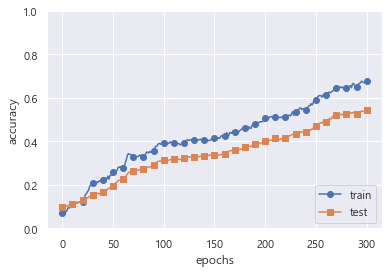

In [3]:
#  드랍아웃의 효율을 확인하기 위해 교재의 MultiLayerNetExtend 클래스 사용 ( 오차역전파 , Relu )
from multi_layer_net_extend import MultiLayerNetExtend
from trainer import Trainer
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.25 # 드랍아웃의 확률 = 뉴런 제거 확률  
# ====================================================

# 교재의 있는 다중신경망 클래스 , 히든레이어 5개 , 뉴런은 각각 100개로 지정.

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100,100,100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list



# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 드랍아웃 코멘트 

    - 히든레이어가 5개인 다중신경망에서 25% 확률로 뉴런을 제거하였더니 
    드랍아웃을 사용하지 않았을 경우 와 비교해 볼 때, 눈에 띄게 오버피팅 문제가 해결 된 것을 알 수 있다.
    
### 드랍아웃 False 시 그래프 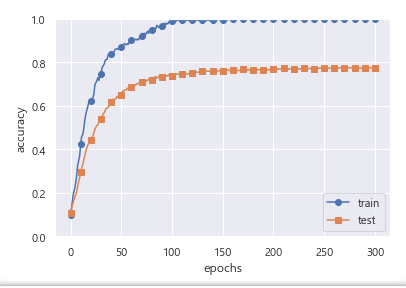

## 신경망 학습개선 : 가중치 초기화 - He 
    
    -  처음 w 값들이 평균이 0 , 표준편차가 1 인 정규분포를 이용해 가중치 초기화 할 경우 
    출력값이 0 또는 1에 치우치는 현상이 발생하게 된다 ( sigmoid 함수의 경우 ) 
    - Relu 함수를 사용 할 경우 , 출력값이 0 에 치우치는 현상이 발생하게 되는데,
    이를 방지하고자 w 값에 He 초기값을 사용하여 출력값이 정규분포 모양처럼 골고루 출력 되게끔 
    가중치 초기화를 추가하고자 한다.
    
    - 가중치 함수에서 np.sqrt(input_size/2) 를 추가하여 표준편차 로 설정한다.

## std =1 , Xavier , He 초기화 비교 시각화

===========iteration:0===========
std=0.01:2.3025132616607196
Xavier:2.2968047181617797
He:2.424675130979375
===========iteration:100===========
std=0.01:2.3020412710650078
Xavier:2.244665338499841
He:1.3985330973019523
===========iteration:200===========
std=0.01:2.302565586670872
Xavier:2.13308175812994
He:0.8166728509290577
===========iteration:300===========
std=0.01:2.3017918998088973
Xavier:1.8597380546070623
He:0.5329784220701415
===========iteration:400===========
std=0.01:2.3019202373221184
Xavier:1.304760012292454
He:0.3509942878397956
===========iteration:500===========
std=0.01:2.3027187859170812
Xavier:0.9622058665279005
He:0.38926277270586973
===========iteration:600===========
std=0.01:2.302082843541791
Xavier:0.6606765105825789
He:0.4050369252791455
===========iteration:700===========
std=0.01:2.2991085327509504
Xavier:0.5139816382878373
He:0.3325032246104114
===========iteration:800===========
std=0.01:2.3021820021012536
Xavier:0.4627820379949892
He:0.3044116849163856


Text(0.5, 0, 'iterations')

Text(0, 0.5, 'loss')

(0.0, 2.5)

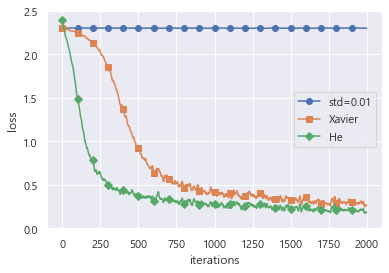

In [8]:
from util import smooth_curve
from multi_layer_net import MultiLayerNet
from optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    
    # 교재의 다중신경망 클래스 사용 , 히든레이어 4개 , 뉴런 각각 100개 
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### Xavier , He 코멘트

    - 히든레이어가 4개인 다중신경망-오차역전파 에선,
    std 가 0.01 일 경우 보다, Xavier 초기값 0.4 , He 초기값 0.27 을 사용하는것이 더 정확한 학습효과를 보여준다. 

## He 초기값 적용 후 실행 

In [9]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 

class FourLayerNet_He():  

    # Relut / He 초기값  적용 (= (2.0/size_list[idx - 1]) )
    
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3 , output_size):
        size_list = [input_size] + [hidden_size1] + [hidden_size2] + [hidden_size3] + [output_size]
        idx = 4 # 레이어 갯수 
        self.params = {}
        self.params['W1']=np.sqrt(2.0/size_list[idx - 1])*np.random.randn(input_size, hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=np.sqrt(2.0/size_list[idx - 1])* np.random.randn(hidden_size1, hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=np.sqrt(2.0/size_list[idx - 1])* np.random.randn(hidden_size2, hidden_size3)
        self.params['b3']=np.zeros(hidden_size3)
        self.params['W4']=np.sqrt(2.0/size_list[idx - 1])* np.random.randn(hidden_size3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu()    
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        self.layers['Relu']=Relu()
        
        self.lastlayer = SoftmaxWithLoss()   
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    
    def loss(self, x, t):
    
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    
    def accuracy(self,x,t):
        
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치를 찍게 됨.
        if t.ndim != 1 : t=np.argmax(t,axis =1) # 타겟 벨류가 1이 아니면 , t=np.argmax(t,axis =1)
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    
    # 경사하강법 (dw) 
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])  
        return grads
    
    # 오차역전파 
    def gradient(self, x, t):
        
            self.loss(x,t)
            dout = 1
            dout = self.lastlayer.backward(dout)            
            layers = list(self.layers.values())
            layers.reverse()
            for layer in layers:
                dout = layer.backward(dout)        
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
            grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
            grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db  
            return grads

In [10]:
from optimizer import *
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

#  He 초기화 적용된 다중신경망 클래스 적용 히든레이어 3개, 뉴런은 각각 4개 

network = FourLayerNet_He(input_size=784 , hidden_size1= 100 , hidden_size2= 100 , hidden_size3= 100 , output_size= 10 )
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
momentum = 0.9
v = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

# 모멘텀 

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if v is None:
        v = {}
        for key, val in network.params.items():
            v[key] = np.zeros_like(val)
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

트레이닝 결과값= 0.093 테스트_결과값= 0.092
트레이닝 결과값= 0.937 테스트_결과값= 0.935
트레이닝 결과값= 0.954 테스트_결과값= 0.951
트레이닝 결과값= 0.964 테스트_결과값= 0.96


## He 코멘트 

    - He 초기값을 사용한 후 , 짧은 학습횟수에도 1에 빠르게 가까워지는 학습속도를 확인 할 수있다.

## 매개변수 갱신 : SGD , AdaGrad , Momentum , Adam 비교 시각화

    - 손실함수의 기울기를 계산하고, 학습률을 곱한 값으로 업데이트 하여 
     매개변수 값을 반복 갱신한 후, 최적의 값에 다가가는 확률적 경사 하강법  SGD.
    
    - 이동평균 ( 속도(v) , 가속도(dw) 를 이용해 매개변수를 갱신하고 최적의 값에 다가가는 모멘텀. (Momentum) 
    
    - 학습이 제대로 이루워지기 위해 학습을 진행하면서 학습률을 점차 줄여서 매개변수를 갱신하는 AdaGrad. 
    
    - 모멘텀과 AdaGrad 동시에 사용하여 최적의 값을 찾는 Adam. 등이 있다.
    
    - 교재에 있는 시각화 클래스를 사용하여 각각 매개변수 갱신이 어떤 학습개선을 보여주는지 확인한다.

C:\Users\Hyobin An\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyobin An\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


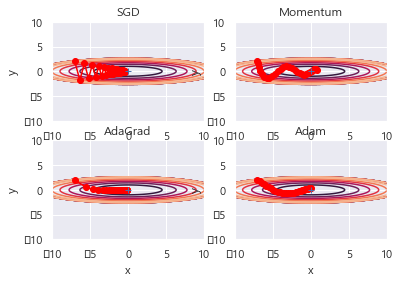

In [11]:
from collections import OrderedDict
from optimizer import *

class parameter(FourLayerNet):

    def f(x, y):
        return x**2 / 20.0 + y**2


    def df(x, y):
        return x / 10.0, 2.0*y
    
    # 시작점 (-7.0 , 2.0 )
    
    init_pos = (-7.0, 2.0)
    params = {}
    params['x'], params['y'] = init_pos[0], init_pos[1]
    grads = {}
    grads['x'], grads['y'] = 0, 0


    optimizers = OrderedDict()
    optimizers["SGD"] = SGD(lr=0.95)
    optimizers["Momentum"] = Momentum(lr=0.1)
    optimizers["AdaGrad"] = AdaGrad(lr=1.5)
    optimizers["Adam"] = Adam(lr=0.3)

    idx = 1

    for key in optimizers:
        optimizer = optimizers[key]
        x_history = []
        y_history = []
        params['x'], params['y'] = init_pos[0], init_pos[1]

        for i in range(30):
            x_history.append(params['x'])
            y_history.append(params['y'])

            grads['x'], grads['y'] = df(params['x'], params['y'])
            optimizer.update(params, grads)


        x = np.arange(-10, 10, 0.01)
        y = np.arange(-5, 5, 0.01)

        X, Y = np.meshgrid(x, y) 
        Z = f(X, Y)

        # 외곽선 단순화
        mask = Z > 7
        Z[mask] = 0

        # 그래프 그리기
        plt.subplot(2, 2, idx)
        idx += 1
        plt.plot(x_history, y_history, 'o-', color="red")
        plt.contour(X, Y, Z)
        plt.ylim(-10, 10)
        plt.xlim(-10, 10)
        plt.plot(0, 0, '+')
        #colorbar()
        #spring()
        plt.title(key)
        plt.xlabel("x")
        plt.ylabel("y")

    plt.show()

## 매개변수 갱신 : 그래프 시각화

===========iteration:0===========
SGD:2.3024454829633925
Momentum:2.302485983439293
AdaGrad:2.2625928934464934
Adam:2.301358044424489
===========iteration:100===========
SGD:2.3020139725608746
Momentum:2.3000367883935073
AdaGrad:0.20876081979460281
Adam:0.5146073837183583
===========iteration:200===========
SGD:2.301606381165448
Momentum:2.299040853527466
AdaGrad:0.16026515208304265
Adam:0.4357414287804471
===========iteration:300===========
SGD:2.2988999762241082
Momentum:2.2902517530316606
AdaGrad:0.08849817405513333
Adam:0.19925693328278027
===========iteration:400===========
SGD:2.302511785593813
Momentum:2.3028684483263535
AdaGrad:0.1000808156400683
Adam:0.15142092313207067
===========iteration:500===========
SGD:2.303335024959177
Momentum:2.3054978933662293
AdaGrad:0.06546950249069283
Adam:0.14210935134649344
===========iteration:600===========
SGD:2.304928580352991
Momentum:2.308957331030772
AdaGrad:0.07461771502004116
Adam:0.11760846572496676
===========iteration:700===========

Text(0.5, 0, 'iterations')

Text(0, 0.5, 'loss')

(0.0, 1.0)

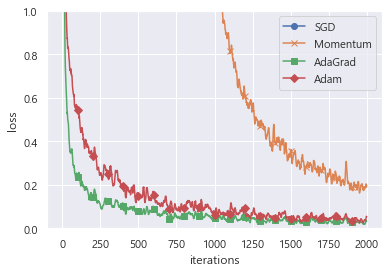

In [12]:
from util import smooth_curve
from optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    # 히든레아어 3개인 다중신경망-오차역전파 사용
    networks[key] = FourLayerNet(input_size=784, hidden_size_1 = 300 , hidden_size_2= 200 , hidden_size_3= 100 , output_size= 10 ) 
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### 시각화 코멘트

    - 각각 매개변수 갱신 방법의 시작점을 (-7.0 , 2.0 ) 으로 했을때
    - 기울기의 방향,이동평균,지수이동평균 등을 사용한 매개변수 갱신방법들의 최적의 값을 찾는 방향을 알 수 있다.
    
    - SGD 는 지그재그로 이동하면서 비효율적인 움직임을,
    - 모멘텀은 기울기 방향으로 힘을 받아 물체가 가속되지만, 상하의 이동이 큰 움직임을,
    - AdaGrad 는 학습이 지연될수록 올바른 방향으로 최적의 값을 찾는 움직임을,
    - Adam 은 모멘텀을 보완하여 최적의 값을 찾는 움직임을 보여준다. 
    
    - 그래프 시각화를 보면 hidden_layer 가 3개 , 뉴런은 각각 100일때, 
    - Adam 과 AdaGrad 매개변수 갱신이 매우 효율적임을 보여준다.
    ( 모멘텀과 SGD 는 손실함수가 증가/하락, 즉 지그재그 의 형태를 보여줌으로 그래프에서 나타나지 않았다.)

## 신경망 학습개선 : SGD 

In [13]:
from optimizer import *
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 다중신경망 클래스는 기존 오차역전파 만 사용한 클래스 로 사용한다. 
network = FourLayerNet(input_size = 784, hidden_size_1 = 300, hidden_size_2 = 200 , hidden_size_3=100 , output_size = 10) 

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x1 = []
plt_y1 = []

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    

    grad = network.gradient(x_batch, t_batch)
    
    # SGD 방식 사용 
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x1.append(train_acc)
        plt_y1.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))
        
# 트레이닝_ 결과값 , 테스트_결과값 이 천천히 증가했다가 , 빠르게 증가하는 들쑥 날쑥의 형태를 보인다.


트레이닝 결과값= 0.102 테스트_결과값= 0.101
트레이닝 결과값= 0.112 테스트_결과값= 0.114
트레이닝 결과값= 0.848 테스트_결과값= 0.849
트레이닝 결과값= 0.939 테스트_결과값= 0.933


### SGD 코멘트

    - 학습의 진행될수록, 결과값이 느리게 1에 가까워지는것을 알 수 있다.

## 신경망 학습개선 : 모멘텀

In [14]:
from optimizer import *
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 다중신경망 클래스는 기존 오차역전파 만 사용한 클래스 로 사용한다. 

network = FourLayerNet(input_size = 784, hidden_size_1 = 300,hidden_size_2 = 200, hidden_size_3 = 100 , output_size = 10)
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
momentum = 0.9
v = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

# 모멘텀 

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if v is None:
        v = {}
        for key, val in network.params.items():
            v[key] = np.zeros_like(val)
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

트레이닝 결과값= 0.098 테스트_결과값= 0.097
트레이닝 결과값= 0.112 테스트_결과값= 0.114
트레이닝 결과값= 0.732 테스트_결과값= 0.74
트레이닝 결과값= 0.923 테스트_결과값= 0.92


### 모멘텀 코멘트, 
    -  hidden_layer 3개로 구성한 클래스에선, 
    - 모멘텀은, SGD 보다 만족스럽지 못한 학습결과를 보여준다.

## 신경망 학습개선 : AdaGrad

In [15]:
from optimizer import *
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 다중신경망 클래스는 기존 오차역전파 만 사용한 클래스 로 사용한다. 

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100,100,100,100,100],
                                  output_size=10, weight_init_std=weight_type)
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
h = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

# AdaGrad 

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if h is None:
        h = {}
        for key, val in network.params.items():
            h[key] = np.zeros_like(val)
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        h[key] += h[key]  * grad[key]
        network.params[key] -= learning_rate * grads[key] / (np.sqrt(h[key]) + 1e-7)
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

ValueError: operands could not be broadcast together with shapes (784,300) (784,100) 

## 신경망 학습개선 : Adam
    - 죄송합니다.

In [5]:
from optimizer import *
from multi_layer_net import *
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 다중신경망 클래스는 기존 오차역전파 만 사용한 클래스 로 사용한다. 

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std='relu')
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100

learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
iter_ = 0
m = None
v = None



train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

# Adam

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if m is None:
        m , v  = {} , {}
        for key, val in network.params.items():
            m[key] = np.zeros_like(val)
            v[key] = np.zeros_like(val)
            
        iter_ += 1
        lr_t  = learning_rate * np.sqrt(1.0 - beta2**iter_) / (1.0 - beta1**iter_) 
            
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        
        m[key] += (1 - beta1) * (grads[key] - m[key])  # 상하 
        v[key] += (1 - beta2) * (grads[key]**2 - v[key]) # 좌우 
            
        params[key] -= lr_t * m[key] / (np.sqrt(v[key]) + 1e-7)
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
########################################################################################  

    self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
    self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            
    unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
    unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
    params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)
    
########################################################################################

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

NameError: name 'grads' is not defined

In [ ]:
from optimizer import *
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 다중신경망 클래스는 기존 오차역전파 만 사용한 클래스 로 사용한다. 

network = FourLayerNet(input_size = 784, hidden_size_1 = 100,hidden_size_2 = 100, hidden_size_3 = 100 , output_size = 10)
iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100

learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
iter_ = 0
m = None
v = None



train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []

# Adam

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if m is None:
        m , v  = {} , {}
        unbias_m , unbisa_b = {} , {} 
        for key, val in network.params.items():
            m[key] = np.zeros_like(val)
            v[key] = np.zeros_like(val)
            
        iter_ += 1
        lr_t  = learning_rate * np.sqrt(1 - beta2**iter_) / (1- beta1**iter_) 
            
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        
            m[key] = (beta1*m[key]) + (1 - beta1) * grads[key]
            v[key] = (beta2*v[key]) + (1 - beta2)*(grads[key]**2)
            
            unbias_m += (1 - beta1) * (grads[key] - m[key]) # correct bias
            unbisa_b += (1 - beta2) * (grads[key]*grads[key] - v[key]) # correct bias
            params[key] += learning_rate * unbias_m / (np.sqrt(unbisa_b) + 1e-7)
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
########################################################################################  
 
            unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)
    
########################################################################################

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3))

## 신경망 학습개선 : 배치 정규화

    - 배치 정규화는 학습 시의 미니배치를 한 단위로 정규화를 하는 것으로 분포의 평균이 0, 분산이 1이 되도록 정규화하는 것을 말한다.
    - 배치 정규화를 추가 해 준다면,
    
    - 1 . 학습속도 가 개선된다.
    - 2 . 가중치 초깃값 선택의 의존성이 낮아진다.
    - 3 . 오버피팅 문제를 방지 할 수 있다. 
    
    - 활성화 함수 Relu() = FourLayerNet_Normal_Relu()
    - 활성화 함수 Sigmoid() = FourLayerNet_Normal_Sigmoid()

In [ ]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 

class FourLayerNet_Batch_Normal_Relu():    
    def __init__(self, input_size, hidden_size_1,hidden_size_2, hidden_size_3  ,output_size, weight_init_std = 0.01):
        
        # 가중치 초기화 
        self.params = {} 
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size_1)
        self.params['b1']=np.zeros(hidden_size_1)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size_1, hidden_size_2)
        self.params['b2']=np.zeros(hidden_size_2)
        self.params['W3']=weight_init_std * np.random.randn(hidden_size_2, hidden_size_3)
        self.params['b3']=np.zeros(hidden_size_3)      
        self.params['W4']=weight_init_std * np.random.randn(hidden_size_3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        # 배치 정규화 추가  ( gamma = 확대 scale , beta = 이동함수 )
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu()
        self.layers['BatchNormalization']=BatchNormalization(gamma= 1.0 , beta=0.0)
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])     
        self.layers['Relu']=Relu()
        self.layers['BatchNormalization']=BatchNormalization(gamma= 1.0 , beta=0.0)
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu() 
        self.layers['BatchNormalization']=BatchNormalization(gamma= 1.0 , beta=0.0)
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        self.layers['Relu']=Relu()
        
        
        self.lastlayer = SoftmaxWithLoss()   
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    
    def loss(self, x, t):
    
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    
    def accuracy(self,x,t):
        
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치를 찍게 됨.
        if t.ndim != 1 : t=np.argmax(t,axis =1) # 타겟 벨류가 1이 아니면 , t=np.argmax(t,axis =1)
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    
    # 경사하강법 (dw) 
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])  
        return grads
    
    # 오차역전파 
    def gradient(self, x, t):
        
            self.loss(x,t)
            dout = 1
            dout = self.lastlayer.backward(dout)            
            layers = list(self.layers.values())
            layers.reverse()
            for layer in layers:
                dout = layer.backward(dout)        
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
            grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
            grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db  
            return grads

In [ ]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 

class FourLayerNet_Batch_Normal_sigmoid():    
    def __init__(self, input_size, hidden_size_1,hidden_size_2, hidden_size_3  ,output_size, weight_init_std = 0.01):
        
        # 가중치 초기화 
        self.params = {} 
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size_1)
        self.params['b1']=np.zeros(hidden_size_1)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size_1, hidden_size_2)
        self.params['b2']=np.zeros(hidden_size_2)
        self.params['W3']=weight_init_std * np.random.randn(hidden_size_2, hidden_size_3)
        self.params['b3']=np.zeros(hidden_size_3)      
        self.params['W4']=weight_init_std * np.random.randn(hidden_size_3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        # 배치 정규화 추가  ( gamma = 확대 scale , beta = 이동함수 )
        self.layers = OrderedDict()
        
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['BatchNormalization']=BatchNormalization(gamma= 1.0 , beta=0.0)
        self.layers['Sigmoid']=Sigmoid()
        
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])  
        self.layers['BatchNormalization']=BatchNormalization(gamma= 1.0 , beta=0.0)
        self.layers['Sigmoid']=Sigmoid()
        
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['BatchNormalization']=BatchNormalization(gamma= 1.0 , beta=0.0)
        self.layers['Sigmoid']=Sigmoid()
        
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        self.layers['BatchNormalization']=BatchNormalization(gamma= 1.0 , beta=0.0)
        self.layers['Sigmoid']=Sigmoid()
        
        
        self.lastlayer = SoftmaxWithLoss()   
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    
    def loss(self, x, t):
    
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    
    def accuracy(self,x,t):
        
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치를 찍게 됨.
        if t.ndim != 1 : t=np.argmax(t,axis =1) # 타겟 벨류가 1이 아니면 , t=np.argmax(t,axis =1)
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    
    # 경사하강법 (dw) 
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])  
        return grads
    
    # 오차역전파 
    def gradient(self, x, t):
        
            self.loss(x,t)
            dout = 1
            dout = self.lastlayer.backward(dout)            
            layers = list(self.layers.values())
            layers.reverse()
            for layer in layers:
                dout = layer.backward(dout)        
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
            grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
            grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db  
            return grads

In [ ]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 배치 정규화가 적용된 4층 레이어 클래스 사용 
network = FourLayerNet_Batch_Normal_Relu(input_size = 784, hidden_size_1 = 300, hidden_size_2 = 200 , hidden_size_3=100 , output_size = 10) 

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x1 = []
plt_y1 = []


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    


    grad = network.gradient(x_batch, t_batch) 
    
    # SGD
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) 
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x1.append(train_acc)
        plt_y1.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3) )
        


In [ ]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

# 배치 정규화가 적용된 4층 레이어 클래스 사용 
network = FourLayerNet_Batch_Normal_sigmoid(input_size = 784, hidden_size_1 = 300, hidden_size_2 = 200 , hidden_size_3=100 , output_size = 10) 

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x1 = []
plt_y1 = []


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    


    grad = network.gradient(x_batch, t_batch) 
    
    # SGD
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) 
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x1.append(train_acc)
        plt_y1.append(test_acc)
        print('트레이닝 결과값=', train_acc.round(3), '테스트_결과값=',test_acc.round(3) )
        


### 배치 정규화 코멘트 
    - SGD 를 사용한  train_acc , test_acc 을 비교해보면 
    - 감마 = 1.0 , 베타 =0.0 으로 배치 정규화 했을때
    - 동일한 학습횟수에도 불과하고 빠르게 1에 수렴하는 결과값을 볼 수 있다.
    
    - 활성화 함수 Sigmoid , Relu 에서의 배치정규화를 비교해 볼 때,
    Relu 함수의 배치정규화가 더 빠르게 결과값이 1에 가까워지는 것을 볼 수 있다.

# 이상입니다. 감사합니다. 15016033 안효빈

In [ ]:
0.9**10